In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

from librosa.core import stft
from librosa.core import istft
from librosa import amplitude_to_db, db_to_amplitude
from librosa.display import specshow
from librosa.output import write_wav

from scipy.signal import butter, lfilter, csd
from scipy.linalg import svd, pinv, inv

from utils import apply_reverb, read_wav
import corpus
import mir_eval

import pyroomacoustics as pra

(-1, 9)

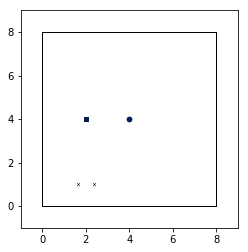

In [2]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)

s1, s2 = map(read_wav, corpus.experiment_files_timit())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([4.,4.], signal=s1)
room.add_source([2.,4.], signal=s2)

R = pra.linear_2D_array(center=[2.,1.], M=2, phi=0, d=0.75)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])

3D case

(0, 6)

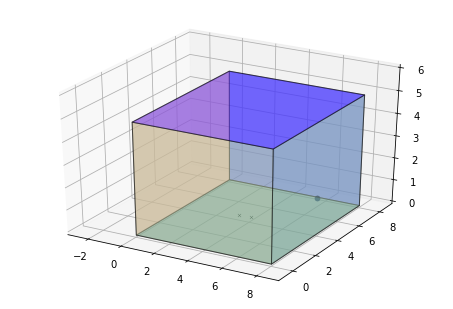

In [3]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)
room.extrude(5.)

s1, s2 = map(read_wav, corpus.experiment_files_timit())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([8.,4.,1.6], signal=s1)
# room.add_source([2.,4.,1.6], signal=s2)
#[[X],[Y],[Z]]
R = np.asarray([[4.75,5.5],[2.,2.],[1.,1]])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
    
fig, ax = room.plot()
ax.set_xlim([-3, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([0, 6])

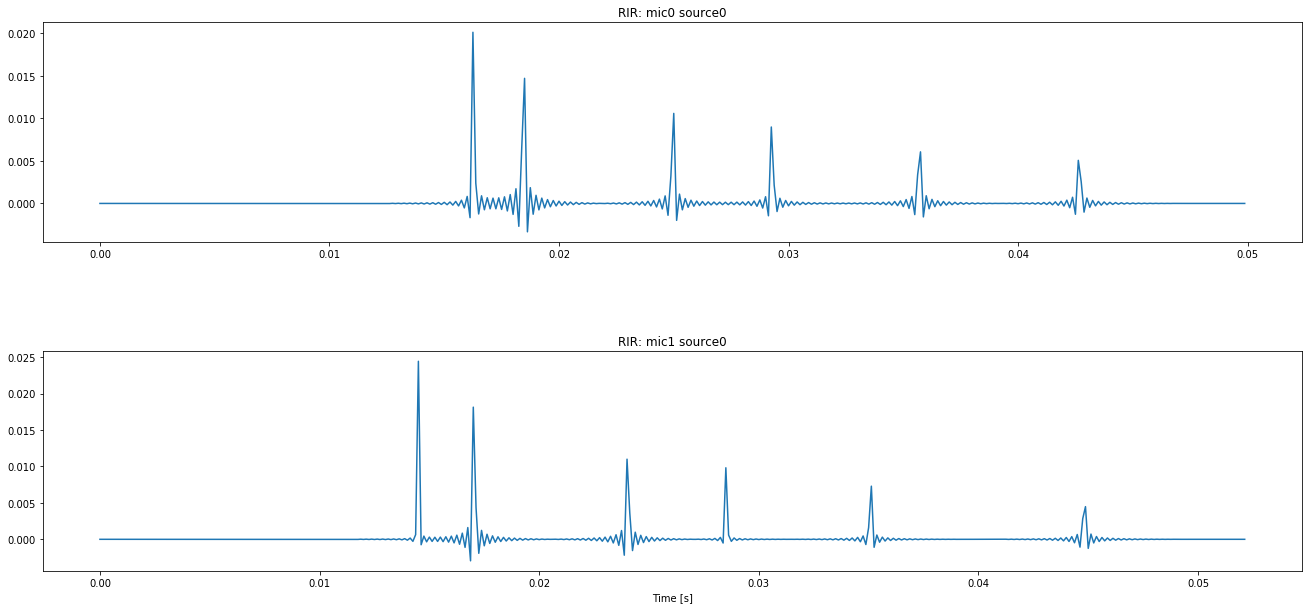

In [4]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [5]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 47214)


In [7]:
nfft=2048
win = 1024
hop = int(nfft/8)
Y1_o = stft(room.mic_array.signals[0,:len(s1)], n_fft=nfft, hop_length=hop, win_length=win)
Y2_o = stft(room.mic_array.signals[1,:len(s1)], n_fft=nfft, hop_length=hop, win_length=win)
X1_o = stft(s1, n_fft=nfft, hop_length=hop, win_length=win)

Gxx = np.abs(X1_o * np.conj(X1_o))
Gxy = np.abs(X1_o * np.conj(Y1_o))
Gyx = np.abs(Y1_o * np.conj(X1_o))
Gyy = np.abs(Y1_o * np.conj(Y1_o))
F,T = Gxx.shape
print(Gxx.shape)
print(Gxy.shape)
print(Gyx.shape)
print(Gyy.shape)

(1025, 183)
(1025, 183)
(1025, 183)
(1025, 183)


(2050, 366)


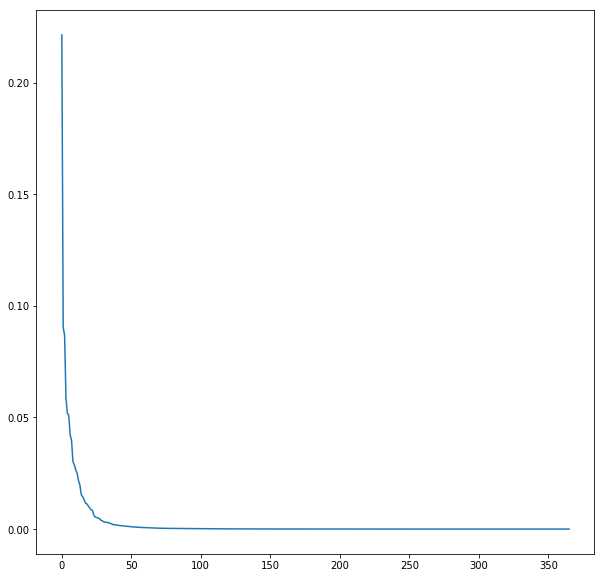

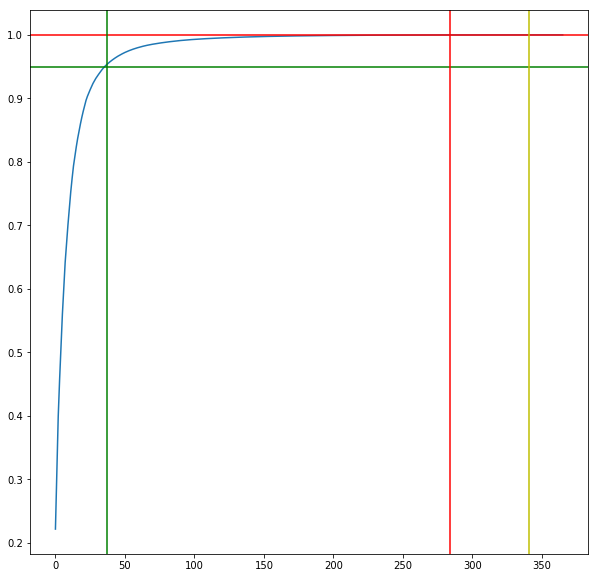

In [8]:
from scipy.linalg import svd, pinv
temp = np.asarray([[Gxx, Gxy],[Gyx, Gyy]]).reshape(F*2,T*2)
print(temp.shape)
U, s, V = svd(temp)
plt.figure(figsize=(10,10))
plt.plot(s/sum(s))
tmpsum = 0
summed = []
for i in range(len(s)):
    tmpsum += s[i]/sum(s)
    summed.append(tmpsum)
summed = np.asarray(summed)
plt.figure(figsize=(10,10))
plt.plot(summed)
plt.axhline(y=0.95, color='g')
plt.axhline(y=0.9999, color='r')
plt.axvline(x=37, color='g')
plt.axvline(x=284, color='r')
plt.axvline(x=341, color='y')

smallUgt1 = U[:,np.where(s>1)].reshape(F*2,-1)
smallUgt10 = U[:,np.where(s>0.5)].reshape(F*2,-1)
smallVgt1 = V[np.where(s>1),:].reshape(-1, T*2)
smallVgt10 = V[np.where(s>0.5),:].reshape(-1, T*2)

Hsgt1 = np.matmul(smallUgt1[:F,:],pinv(smallVgt1[:,T:]).T)
Hsgt10 = np.matmul(smallUgt10[:F,:],pinv(smallVgt10[:,T:]).T)

smallU95p = U[:,:37].reshape(F*2,-1)
smallU9999p = U[:,:284].reshape(F*2,-1)
smallU999999p = U[:,:341].reshape(F*2,-1)
smallV95p = V[:37,:].reshape(-1, T*2)
smallV9999p = V[:284,:].reshape(-1, T*2)
smallV999999p = V[:341,:].reshape(-1, T*2)

Hs95p = np.matmul(smallU95p[:F,:],pinv(smallV95p[:,T:]).T)
Hs9999p = np.matmul(smallU9999p[:F,:],pinv(smallV9999p[:,T:]).T)
Hs999999p = np.matmul(smallU999999p[:F,:],pinv(smallV999999p[:,T:]).T)


/home/tinus/.virtualenvs/general_python2/local/lib/python2.7/site-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


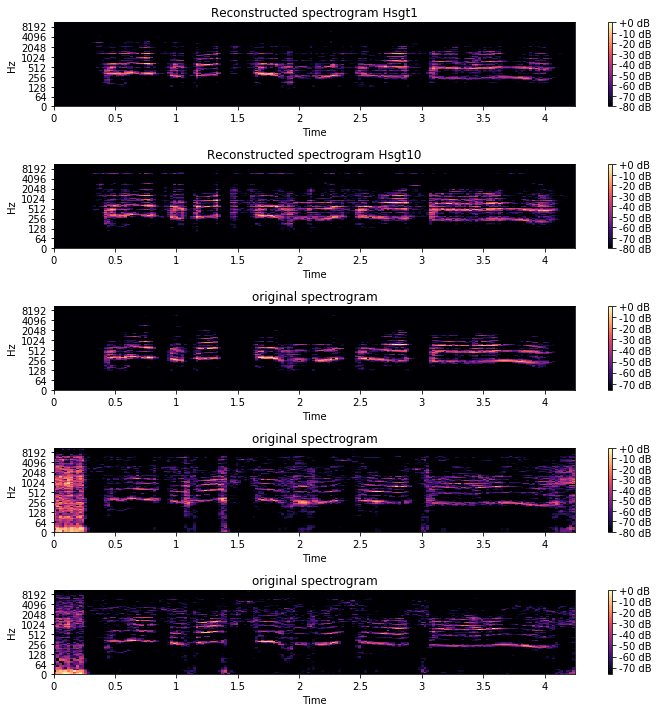

In [9]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(511)
specshow(amplitude_to_db(np.multiply(Hsgt1,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(512)
specshow(amplitude_to_db(np.multiply(Hsgt10,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt10')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(513, sharex=ax1)
specshow(amplitude_to_db(np.multiply(Hs95p,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(514, sharex=ax1)
specshow(amplitude_to_db(np.multiply(Hs9999p,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(515, sharex=ax1)
specshow(amplitude_to_db(np.multiply(Hs999999p,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

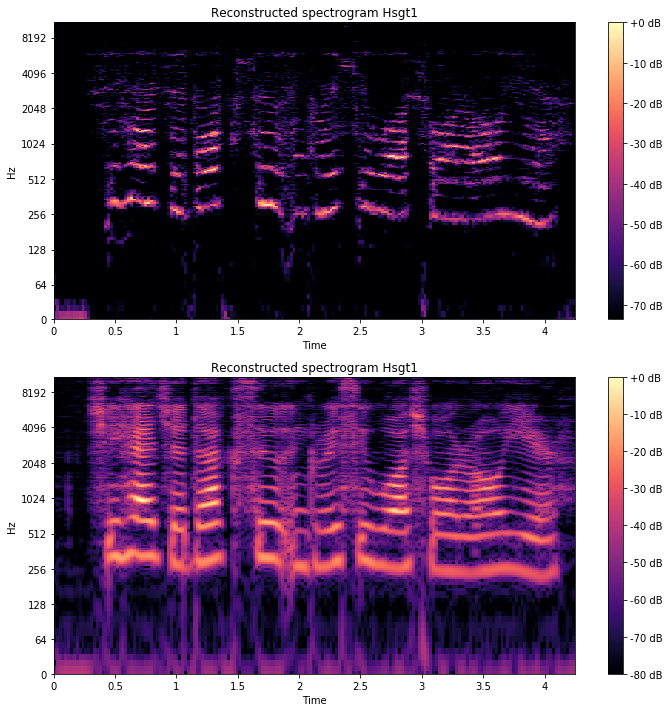

In [15]:
filter_result = np.multiply(pinv(Hs999999p).T,Y1_o)
plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
specshow(amplitude_to_db(filter_result, ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(212)
specshow(amplitude_to_db(Y1_o, ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

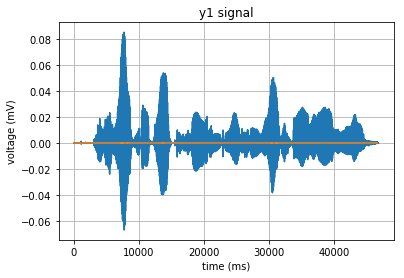

In [13]:
filter_result = np.multiply((Hs999999p),Y1_o)
recon_y1_Hs = istft(filter_result, hop_length=hop, win_length=win)
fig, ax = plt.subplots()
ax.plot(s1)
ax.plot(recon_y1_Hs)


ax.set(xlabel='time (ms)', ylabel='voltage (mV)',
       title='y1 signal')
ax.grid()
